In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import datasets

In [2]:
textprops = dict(fontsize='large', fontfamily='sans serif')
    
def top_countries_proportion(data, category, cmap, n=8, ax=None):
    other = data[n:].sum()
    today_top = data[:n].append(pd.Series(data=other, index=['Others']))
    if not ax:
        fig, ax = plt.subplots(figsize=(16, 6.6))
    explode = np.zeros(n+1)
    explode[:] = 0.02
    norm = mpl.colors.Normalize(vmin=today_top.min()/1.25, vmax=today_top.max()*1.25)
    colors = mpl.cm.get_cmap(cmap)(norm(today_top))
    patches, texts, autotexts = ax.pie(today_top, labels=today_top.index, pctdistance=0.7,
                                       explode=explode, autopct='%.1f%%', textprops=textprops,
                                       colors=colors)
    for t, p in zip(autotexts, patches):
        t.set_fontsize(10)
        if np.array(p.get_facecolor()).prod() < 0.1:
            t.set_color('w')
#     ax.set_title('Global {} proportions'.format(category))

In [3]:
font_dict = dict(fontsize='large', fontfamily='sans serif')

def label(rects, ax):
    for rect in rects:
        width = rect.get_width()
        height = rect.get_height()
        ax.annotate('{}'.format(int(width)),
                    xy=(width, rect.get_y() + height / 2), xytext=(25, 0),
                    textcoords="offset points",ha='center', va='center')

def top_countries(data, category, cmap, n=20):
    data_top = data[:n]

    fig, ax = plt.subplots(figsize=(15, 10))
    color = mpl.cm.get_cmap(cmap)(mpl.colors.LogNorm(vmin=data_top.min()/1.5, vmax=data_top.max()*1.5)(data_top))
    rects = ax.barh(range(data_top.shape[0]), data_top, color=color)
    label(rects, ax)

    ax.set_xlabel('cases ($\\times10^3$)', font_dict)
    ax.set_xticklabels(ax.get_xticks() / 1e3, font_dict)
    ax.set_yticks(range(n))
    ax.set_yticklabels(data_top.index, font_dict)
    ax.invert_yaxis()
    ax.set_title(f'Top {n} countries with the most {category}', font_dict)
    ax.grid(True, axis='x')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax = fig.add_axes([0.45, 0.15, 0.5, 0.5])
    top_countries_proportion(data, category, cmap, ax=ax)
    plt.savefig(f'global/{category}.png', bbox_inches='tight')

In [4]:
__headers = {'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36'}

def str2num(i):
    if i == 'N/A':
        return None
    if i.endswith('%'):
        i = i[:-1]
    return float(i.replace(',', ''))

from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import pandas as pd

# scrape data
req = Request('https://docs.google.com/spreadsheets/u/0/d/e/2PACX-1vR30F8lYP3jG7YOq8es0PBpJIE5yvRVZffOyaqC0GgMBN6yt0Q-NI8pxS7hd1F9dYXnowSC6zpZmW9D/pubhtml/sheet?headers=false&gid=0&range=A1:I206', headers=__headers)
with urlopen(req) as res:
    data = res.read().decode('utf-8')

# parse the html table
soup = BeautifulSoup(data, 'html.parser')
tbody = soup.find('html').find('tbody')
trs = tbody.find_all('tr')
table = []
for tr in trs[6:-3]:
    table.append([str(td.string) for td in tr.find_all('td')[:-1]])
df = pd.DataFrame(table[1:], columns=table[0])

# clean data
df.set_index('LOCATION', inplace=True)
today = df.applymap(str2num)

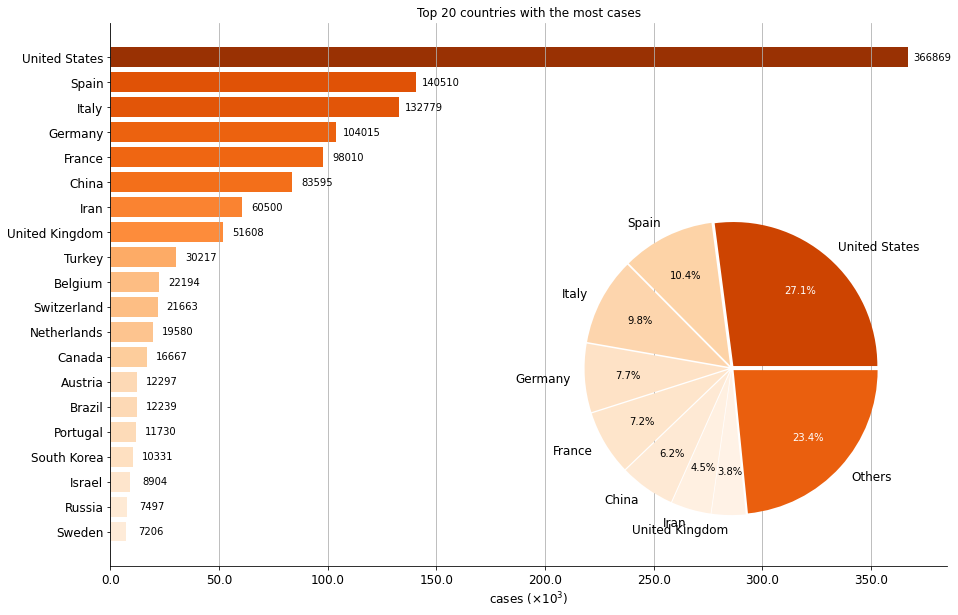

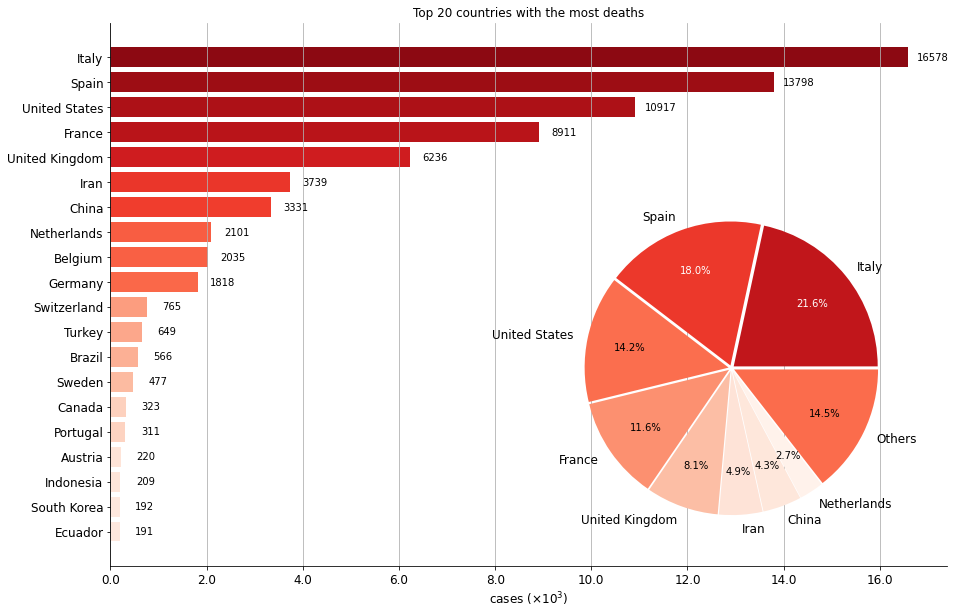

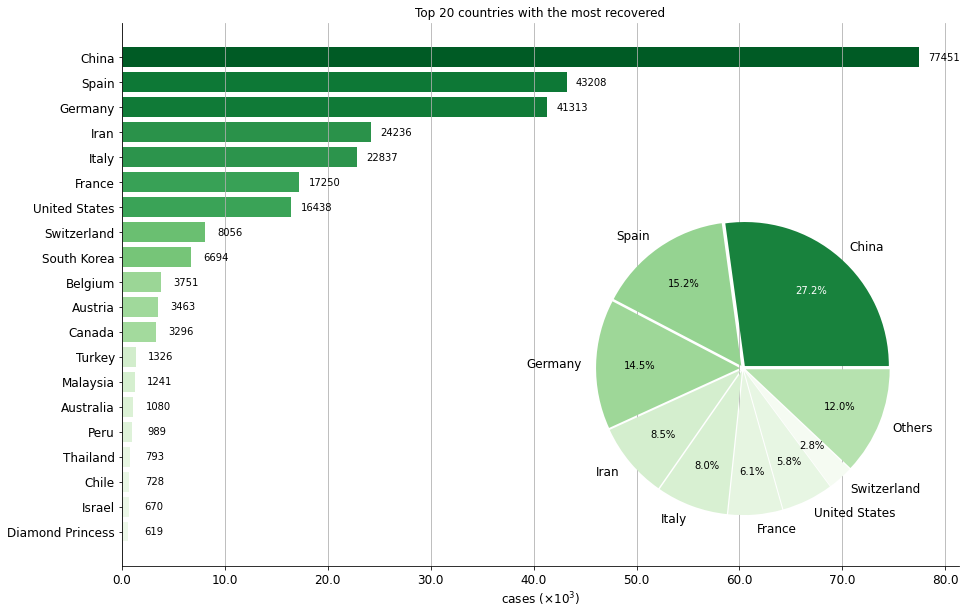

In [5]:
today = datasets.bno()

# sort data by different criteria
today_cases = today.sort_values('Cases', ascending=False)
today_deaths = today.sort_values('Deaths', ascending=False)
today_recovered = today.sort_values('Recovered', ascending=False)

# arugments for ploting
cases = [today_cases['Cases'], 'cases', 'Oranges']
deaths = [today_deaths['Deaths'], 'deaths', 'Reds']
recoverd = [today_recovered['Recovered'], 'recovered', 'Greens']

top_countries(*cases)
top_countries(*deaths)
top_countries(*recoverd)

In [6]:
today.head()

,Cases,New cases,Deaths,New deaths,Death rate,Serious & Critical,Recovered
LOCATION,,,,,,,
United States,366869.0,21.0,10917.0,2.0,2.98,6151.0,16438.0
Spain,140510.0,5478.0,13798.0,629.0,9.82,7069.0,43208.0
Italy,132779.0,232.0,16578.0,55.0,12.49,3898.0,22837.0
Germany,104015.0,894.0,1818.0,46.0,1.75,2646.0,41313.0
France,98010.0,0.0,8911.0,0.0,9.09,7072.0,17250.0


In [11]:
def today_new(ax, category, threshold, color):
    new = today[category].sort_values(ascending=False)
    data = new[new > threshold]
    ax.bar(x=data.index, height=data.values, fc=color)
    ax.set_xticklabels(data.index, rotation=60)
    ax.set_title(f"Countries with over {threshold} new {category.split(' ')[1].lower()} today")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

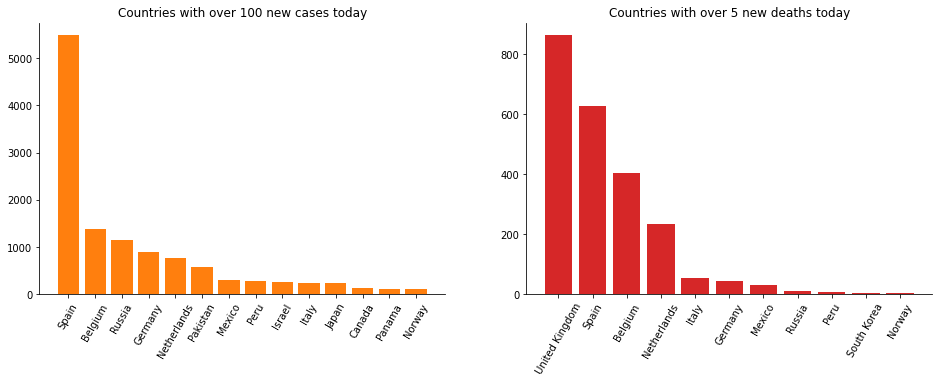

In [16]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
today_new(ax0, 'New cases', 100, 'tab:orange')
today_new(ax1, 'New deaths', 5, 'tab:red')
plt.savefig('global/today_new.png', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 1))
ax.set_xlim(0, 8)
ax.set_ylim(0, 0.75)
ax.axis('off')
font_dict = dict(fontsize=18, ha='left', va='center', wrap=True)
for i, (l, c) in enumerate(today.sum().drop(index=['Unresolved']).iteritems()):
    ax.text(i*1.25, 0.5, l.replace('_Today', ' ').replace('_', '\n'), font_dict) # text
    ax.text(i*1.25, 0, c, font_dict) # number
plt.savefig('global/summary.png', bbox_pad='tight')

In [20]:
# markdown table
global_stat = today.drop(columns=['Death rate']).sum().to_frame().T
global_stat.rename(columns=lambda x: x.replace('_', ' '), inplace=True)
print(global_stat.to_markdown(showindex=False, floatfmt=".0f"))

|   Cases |   New cases |   Deaths |   New deaths |   Serious & Critical |   Recovered |
|--------:|------------:|---------:|-------------:|---------------------:|------------:|
| 1355131 |       12720 |    76703 |         2322 |                39673 |      285074 |
